# Lung segmentation from thoracic X-Ray images with UNET

*by Georgios K. Ouzounis*

In [1]:
# Time cells.

!pip install -q ipython-autotime
%load_ext autotime

     |████████████████████████████████| 1.6 MB 35.4 MB/s 
time: 647 µs (started: 2022-11-06 11:45:26 +00:00)


## Contents

1. [The challenge](#the-challenge)
2. [Get the training data](#get-the-training-data)
3. [Get the code repo](#get-the-code-repo)
4. [Create the model](#create-the-model)
5. [Train the model](#train-the-model)
6. [Inference on test images](#inference-on-test-images)
7. [Acknowledgements](#acknowledgements)

## The challenge <a name="the-challenge"></a>

<img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/title2.png" width = "600"/>

Given an annotated image dataset of lungs from thoracic x-ray images, train a semantic segmentation model (UNET) and compute inference on new, previously unseen images.

**DISCLAIMER:**
In the following, "author" refers to Georgios Ouzounis.

- The work presented in this notebook is independent from past works of the author at varius companies and institutions. It is different with regards to the technology and code used and does not relate to any prior products, research work or IP developed by the author.
- This notebook (code) is developed explicitly for educational purposes, demonstrating how one can train the UNET model. It is not meant for any other usage and the author cannot be held accountable for its outcome and deliverables if used for a purpose different from the one stated.   

**IMPORTANT:** before start working on this notebook change your Runtime setting to GPU.

## Get the training data <a name="get-the-training-data"></a>

For this exercise will use a publicly available dataset of thoracic X-Ray images. It is posted in [kaggle.com](https://www.kaggle.com/nikhilpandey360/chest-xray-masks-and-labels) and is a kind contribution by [Nikhil Pandey](https://www.kaggle.com/nikhilpandey360). The archived collection is approximately 9.58 GB in size.

In [4]:
import os

def run_cmd(cmd, verbose=False, *args, **kwargs) -> None:
    """
    Run system command as a subprocess
    """
    import subprocess

    process = subprocess.Popen(cmd,
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               text=True,
                               shell=True)
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)


def configure_kaggle(config_file: str=""):
    """
    Configure Kaggle CLI

    Args:
        config_file (str): Kaggle config JSON file path
    """    
    import sys
    from google.colab import drive

    if not config_file:
        kaggle_config_file = "MyDrive/.kaggle/kaggle.json"

    KAGGLE_CONFIG = "~/.kaggle/kaggle.json"
    dir_path = os.path.dirname(os.path.realpath(KAGGLE_CONFIG))
    run_cmd(f"mkdir -p {dir_path}")    
    if "MyDrive" in config_file:
        print("Found a Goolge Drive path, connecting to Google drive")
        drive.mount("/content/google_drive", force_remount=True)
        run_cmd(f"cp /content/google_drive/{config_file} {KAGGLE_CONFIG}")
        drive.flush_and_unmount()
    else:
        run_cmd(f"cp {config_file} {KAGGLE_CONFIG}")
     
    print("Configured Kaggle")


def download_kaggle_dataset(dataset: str, kaggle_config_file: str="") -> None:
    """
    Download kaggle competition datasets.
    Args:
        dataset (str): Kaggle dataset name
        kaggle_config_file (str): Kaggle config json file path
                                    Default is empty which would be internally be 
                                    treated as google drive location under "MyDrive/.kaggle/kaggle.json"
    """        
    if not kaggle_config_file:
        kaggle_config_file = "MyDrive/.kaggle/kaggle.json"
    configure_kaggle(kaggle_config_file)
    print(f"Downloading the dataset \"{dataset}\" from Kaggle")
    run_cmd(f"kaggle datasets download -d {dataset}")
    dataset_name = dataset.split("/")[1]
    print(f"Extracting \"{dataset_name}\" dataset")
    run_cmd(f"unzip -q {dataset_name}.zip -d {dataset_name}")
    run_cmd(f"rm -f {dataset_name}.zip")

download_kaggle_dataset("nikhilpandey360/chest-xray-masks-and-labels")

Found a Goolge Drive path, connecting to Google drive
Mounted at /content/google_drive
Configured Kaggle
Extracting "chest-xray-masks-and-labels" dataset
time: 8min 48s (started: 2022-11-06 11:46:32 +00:00)


### Connect to Kaggle.com

We will import this dataset into our working  session directly from Kaggle. To read  more on how to import kaggle datasets directly into Google Colab please refer to this [documentation page](https://www.kaggle.com/general/74235).

In [3]:
# # install the kaggle API
# !pip install -q kaggle

time: 348 µs (started: 2022-11-06 11:44:48 +00:00)


In [4]:
# # create a kaggle directory
# !mkdir ~/.kaggle 

time: 399 µs (started: 2022-11-06 11:44:48 +00:00)


Right-click on the side bar and select Upload File in the root directory. Choose your kaggle.json token.

In [5]:
# # move the token into the kaggle directory
# !mv /content/kaggle.json ~/.kaggle/

time: 229 µs (started: 2022-11-06 11:44:48 +00:00)


In [6]:
# # change the permisions of the file
# !chmod 600 ~/.kaggle/kaggle.json

time: 535 µs (started: 2022-11-06 11:44:48 +00:00)


In [7]:
# # test it out
# !kaggle datasets list

time: 382 µs (started: 2022-11-06 11:44:48 +00:00)


###  Get the dataset

In [8]:
# # start the download
# !kaggle datasets download 'nikhilpandey360/chest-xray-masks-and-labels'

time: 362 µs (started: 2022-11-06 11:44:48 +00:00)


the above takes approximately 4 min to complete

### Setup the project data directories

Let us now create our dataset directory structure

In [5]:
%mkdir dataset
%mkdir dataset/images # for source images
%mkdir dataset/masks # for annotation masks
%mkdir dataset/test # for test images
%mkdir dataset/temp # temp storage

time: 568 ms (started: 2022-11-06 11:55:27 +00:00)


### Uncompress the archive

You will get a warning message about the storage usage which you may ignore as the dataset fits into the available space

In [6]:
# !unzip chest-xray-masks-and-labels.zip -d dataset/temp/

time: 394 µs (started: 2022-11-06 11:55:28 +00:00)


the above takes approximately 5 min to complete

In [7]:
# remove the original zip file
# %rm chest-xray-masks-and-labels.zip

time: 270 µs (started: 2022-11-06 11:55:30 +00:00)


In [8]:
%mv chest-xray-masks-and-labels/* dataset/temp/ 

time: 113 ms (started: 2022-11-06 11:55:32 +00:00)


In [9]:
%ls dataset/temp/Lung\ Segmentation

ClinicalReadings/  masks/                       NLM-MontgomeryCXRSet-ReadMe.pdf
CXR_png/           NLM-ChinaCXRSet-ReadMe.docx  test/
time: 111 ms (started: 2022-11-06 11:55:32 +00:00)


In [10]:
%mv dataset/temp/Lung\ Segmentation/CXR_png/* dataset/images/
IMAGE_PATH = "/content/dataset/images/"

time: 109 ms (started: 2022-11-06 11:55:33 +00:00)


In [11]:
%mv dataset/temp/Lung\ Segmentation/masks/* dataset/masks/
MASK_PATH = '/content/dataset/masks/'

time: 113 ms (started: 2022-11-06 11:55:35 +00:00)


In [12]:
%mv dataset/temp/Lung\ Segmentation/test/* dataset/test/
TEST_PATH = '/content/dataset/test/'

time: 112 ms (started: 2022-11-06 11:55:36 +00:00)


In [13]:
# clean-up
%rm -rf dataset/temp/
%rm -rf chest-xray-masks-and-labels

time: 733 ms (started: 2022-11-06 11:55:37 +00:00)


| <img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/image1.png" width="300"/> | <img src="https://raw.githubusercontent.com/georgiosouzounis/lung-seg-xray-unet/main/images/mask1.png" width="300"/> |
|:--:|:--:|
|example of an x-ray image | example of the corresponding annotation|

### Harmonize the dataset

Next, we will make several corrections to bring the contents of the ```images/``` and ```masks/``` directories in agreement with the UNET library requirements.

**Step 1:** some of the masks contain the ```_mask``` suffix in their file-name. Every image in the ```images/``` directory needs to have a mask in the ```masks/``` directory of exactly the same name. Thus we need to crop this suffix where ever it appears.

In [14]:
# importing os module
import os

# suffix cropping function
def rchop(s, suffix):
    if suffix and s.endswith(suffix):
        return s[:-len(suffix)]
    return s

suffix = "_mask.png"

# iterate over all mask images and edit the file-names
for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  res = rchop(src, suffix)
  dst = ""
  if src != res:
    dst = rchop(src, suffix) + ".png"
    os.rename(src, dst)

time: 15.9 ms (started: 2022-11-06 11:55:46 +00:00)


**Step 2:** Not all source images have corresponding mask images. We need to identify those that don't and remove them (place them in temp directory)

In [15]:
# check the number of files in the images/ and masks/ directories
import os.path

print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

number of files in images/ directory: 800
number of files in masks/ directory: 704
time: 5.69 ms (started: 2022-11-06 11:55:49 +00:00)


In [16]:
# function to confirm the existence of a file in a given directory
def searchFile(fileName, TARGET_PATH):
  for root, dirs, files in os.walk(TARGET_PATH):
    for Files in files:
      #print(Files)
      found = Files.find(fileName)
      if found != -1:
        break
  return found

time: 1.26 ms (started: 2022-11-06 11:55:52 +00:00)


In [17]:
%mkdir /content/dataset/orphan_images

time: 113 ms (started: 2022-11-06 11:55:55 +00:00)


In [18]:
# clean up the images/ directory by removing all images that do not have a mask
import shutil 

cnt = 0

for count, filename in enumerate(os.listdir("/content/dataset/images")):
  found = searchFile(filename, MASK_PATH)
  if found == -1:
    cnt = cnt + 1
    src = "/content/dataset/images/" + filename 
    dst = "/content/dataset/orphan_images/" + filename
    dest = shutil.move(src, dst) 
print("number of files not matched: " + str(cnt))

number of files not matched: 96
time: 599 ms (started: 2022-11-06 11:55:57 +00:00)


In [19]:
# confirm consistency
print("number of files in images/ directory: " + str(len([name for name in os.listdir("/content/dataset/images/")])))
print("number of files in masks/ directory: " + str(len([name for name in os.listdir("/content/dataset/masks/")])))

number of files in images/ directory: 704
number of files in masks/ directory: 704
time: 4.07 ms (started: 2022-11-06 11:56:00 +00:00)


**Step 3:** convert mask images to binary. If there exist multiple classes one needs to set a unique pixel value for each class and re-format the mask images accordingly. In this case we have one class only (lungs) thus each image needs to be binary; 0 for background and 1 for lungs.

In [20]:
import cv2

for count, filename in enumerate(os.listdir("/content/dataset/masks")):
  src = "/content/dataset/masks/" + filename
  img = cv2.imread(src, cv2.IMREAD_GRAYSCALE)
  (T, res) = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY)
  cv2.imwrite(src, res)

time: 52.4 s (started: 2022-11-06 11:56:04 +00:00)


the above takes approximately 60 sec to execute

## Get the code repo <a name="get-the-code-repo"></a>

The code repo is an edited version of Divan Gupta's [Image-Segmentation-Keras](https://github.com/divamgupta/image-segmentation-keras), to support Keras in TF2.5.

In [21]:
!git clone https://github.com/georgiosouzounis/semantic-segmentation-tf2.git

Cloning into 'semantic-segmentation-tf2'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 36 (delta 2), reused 32 (delta 2), pack-reused 0
Unpacking objects: 100% (36/36), done.
time: 924 ms (started: 2022-11-06 11:56:56 +00:00)


In [22]:
%cd semantic-segmentation-tf2/

/content/semantic-segmentation-tf2
time: 9.13 ms (started: 2022-11-06 11:56:57 +00:00)


## Create the model <a name="create-the-model"></a>

Before we create the model let us first find a reasonable set of dimensions to resize our input images to. 


In [23]:
# check the image attributes
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/dataset/test/CHNCXR_0194_0.png")
img.shape

(2992, 2991, 3)

time: 213 ms (started: 2022-11-06 11:56:57 +00:00)


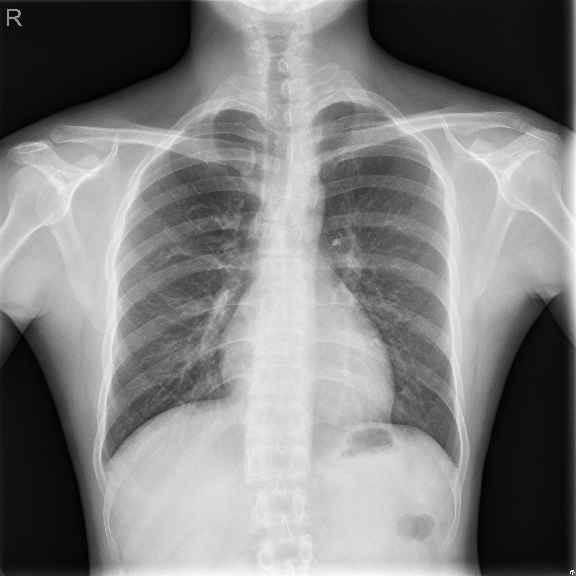

time: 147 ms (started: 2022-11-06 11:56:57 +00:00)


In [24]:
img = cv2.resize(img, (576, 576))
cv2_imshow(img)

In [25]:
# import the vgg_unet model
from tf2_sem_seg.models.unet import vgg_unet

time: 7.81 s (started: 2022-11-06 11:56:57 +00:00)


In [26]:
# instantiate our model:
# + n_classes = 1 (background) + 1 (lungs)
# + input_height: resized number of rows for input image; must be divisable by 32
# + input_width:  resized number of cols for input image; must be divisable by 32
model = vgg_unet(n_classes=2, input_height=576, input_width=576)

58889256/58889256 [==============================] - 7s 0us/step
time: 10.5 s (started: 2022-11-06 11:57:05 +00:00)


Let us now review the model we just instantiated and compare it against the u-net and vgg16 architectures.


| <img src="https://github.com/georgiosouzounis/lung-seg-xray-unet/raw/main/images/unet.png" width="500"/> | <img src="https://github.com/georgiosouzounis/lung-seg-xray-unet/raw/main/images/vgg16.png" width="500"/> |
|:---:|:---:|
|the u-net architecture | the vgg16 architecture |

In [27]:
# review the model
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 576, 576, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 576, 576, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 576, 576, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

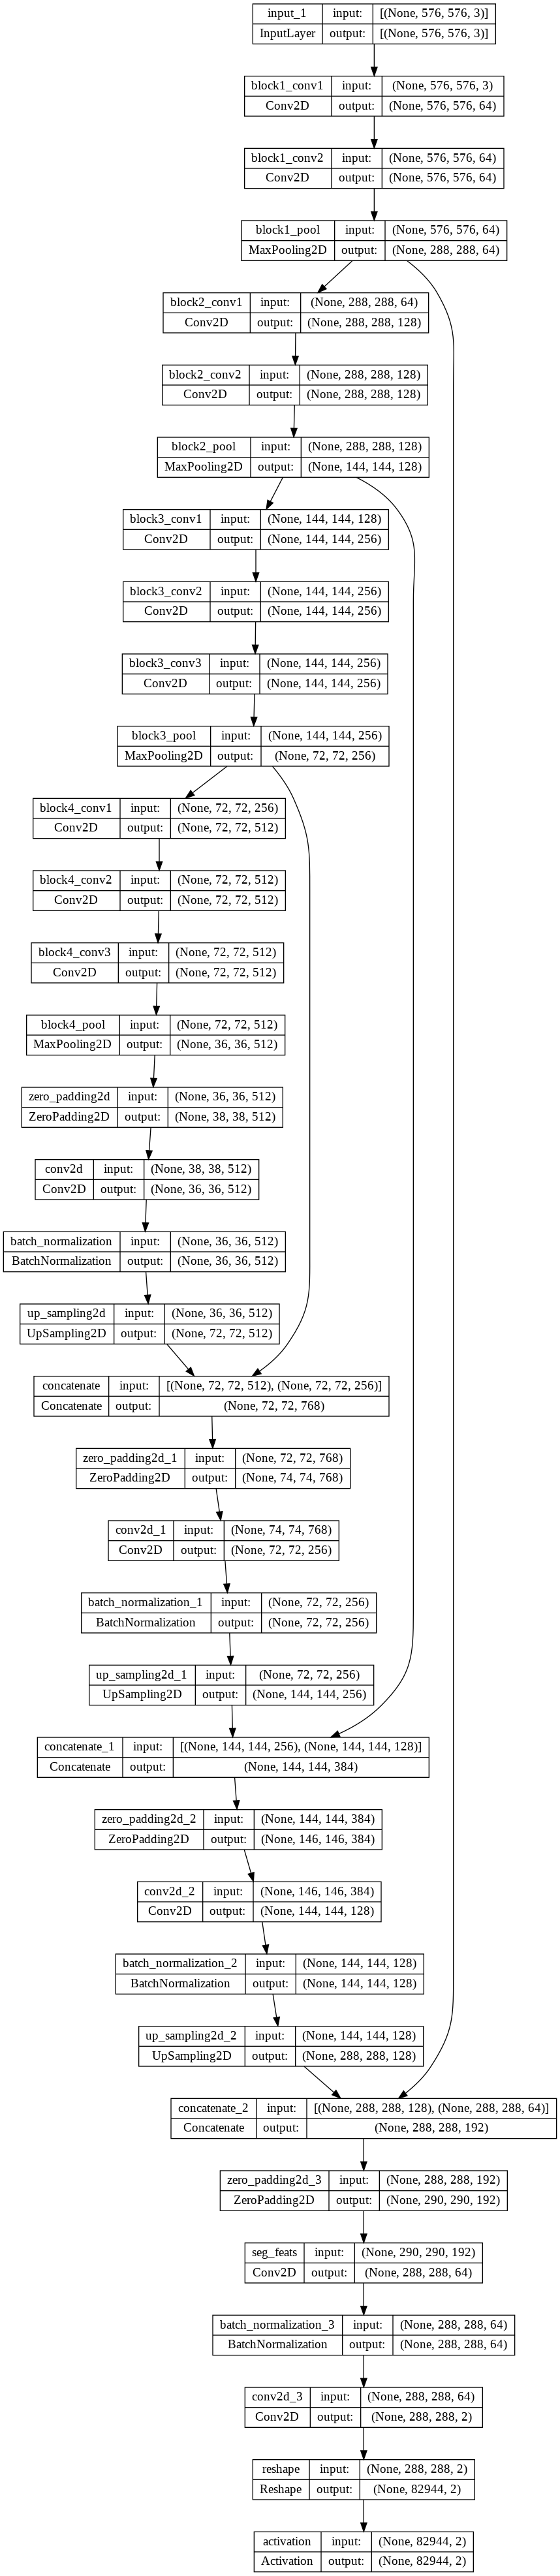

time: 451 ms (started: 2022-11-06 11:57:23 +00:00)


In [28]:
# review the model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Train the model <a name="train-the-model"></a>

In [29]:
# create a temporary directory for model checkpoints
%mkdir /content/tmp/

time: 144 ms (started: 2022-11-06 11:57:30 +00:00)


In [30]:
# train_images: directory containing the source images for training
# train_annotations: directory containing the masks for training
# checkpoints_path: directory for storing weights and logs
# epochs: the number of training epochs set to 5 for the demo. 
#   Increase this to a higher number for better results.
model.train(
    train_images =  "../dataset/images/",
    train_annotations = "../dataset/masks/",
    checkpoints_path = "../tmp/vgg_unet_1" , epochs=5 
)

Verifying training dataset


100%|██████████| 704/704 [02:14<00:00,  5.22it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9548
Epoch 1: saving model to ../tmp/vgg_unet_1.00001
512/512 [==============================] - 238s 436ms/step - loss: 0.1215 - accuracy: 0.9548
Epoch 2/5
512/512 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9768
Epoch 2: saving model to ../tmp/vgg_unet_1.00002
512/512 [==============================] - 222s 434ms/step - loss: 0.0650 - accuracy: 0.9768
Epoch 3/5
512/512 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9793
Epoch 3: saving model to ../tmp/vgg_unet_1.00003
512/512 [==============================] - 223s 436ms/step - loss: 0.0572 - accuracy: 0.9793
Epoch 4/5
512/512 [==============================] - ETA: 0s - loss: 0.0567 - accuracy: 0.9795
Epoch 4: saving model to ../tmp/vgg_unet_1.00004
512/512 [==============================] - 225s 440ms/step - loss: 0.0567 - accuracy: 0.9795
Epoch 5/5
512/512 [==============

In [31]:
# make a backup in your Google Drive
%cp /content/tmp/* /content/drive/MyDrive/deep-learning/lung-seg-xray/

cp: target '/content/drive/MyDrive/deep-learning/lung-seg-xray/' is not a directory
time: 204 ms (started: 2022-11-06 12:18:39 +00:00)


## Inference on test images <a name="inference-on-test-images"></a>

In [32]:
out = model.predict_segmentation(
    inp="/content/dataset/test/CHNCXR_0025_0.png",
    out_fname="/content/tmp/out.png"
)

1/1 [==============================] - 3s 3s/step
time: 6.04 s (started: 2022-11-06 12:18:39 +00:00)


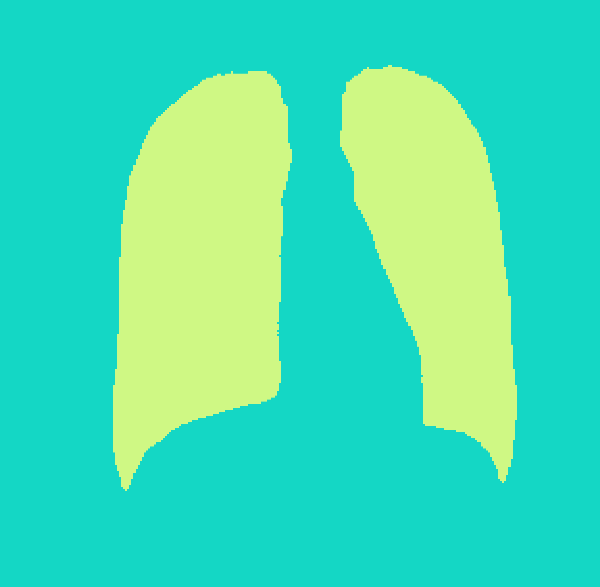

time: 132 ms (started: 2022-11-06 12:18:45 +00:00)


In [33]:
img = cv2.imread("/content/tmp/out.png")
img = cv2.resize(img, (int(img.shape[1]/5), int(img.shape[0]/5)))
cv2_imshow(img)


In [34]:
# alpha-blend the inference with the source
o = model.predict_segmentation(
    inp="/content/dataset/test/CHNCXR_0025_0.png",
    out_fname="/content/tmp/out_blend.png" , overlay_img=True, show_legends=True,
    class_names = ["background","lungs"]
)

1/1 [==============================] - 0s 20ms/step
time: 1.67 s (started: 2022-11-06 12:18:46 +00:00)


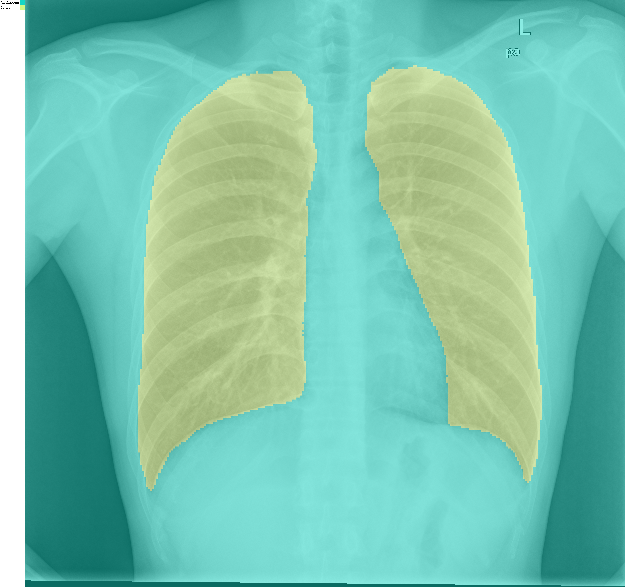

time: 345 ms (started: 2022-11-06 12:18:47 +00:00)


In [35]:
img = cv2.imread("/content/tmp/out_blend.png")
img = cv2.resize(img, (int(img.shape[1]/5), int(img.shape[0]/5)))
from google.colab.patches import cv2_imshow
cv2_imshow(img)

## Acknowledgements <a name="acknowledgements"></a>

The author would like to thank and acknowledge the following:

- [Divan Gupta](https://github.com/divamgupta) and all other contributors to the ```Image Segmentation Keras : Implementation of Segnet, FCN, UNet, PSPNet and other models in Keras``` [repo](https://github.com/divamgupta/image-segmentation-keras) for their amazing work in putting all the functionality together to make semantic segmentation accessible through Keras.
- [Nikhil Pandey](https://www.kaggle.com/nikhilpandey360) for posting an excellent quality X-Ray dataset of thoracic scans in Kaggle.  